In [3]:
# Cell 1: Import necessary libraries
import os
import re
import string
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

print(f"TensorFlow version:{tf.__version__}")

/Users/george/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version:2.14.0


In [4]:
# Cell 2: Define constants and load datasets
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'OrganizedDataToxic', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'OrganizedDataToxic', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'OrganizedDataToxic', 
    batch_size=batch_size)

Found 159571 files belonging to 2 classes.
Using 127657 files for training.
Found 159571 files belonging to 2 classes.
Using 31914 files for validation.
Found 159571 files belonging to 2 classes.


In [5]:
# Cell 3: Define custom text standardization function
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [6]:
# Cell 4: Define text vectorization parameters and create vectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [7]:
# Cell 5: Adapt the vectorization layer to the training data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [8]:
# Cell 6: Define functions for vectorizing text data
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [9]:
# Cell 7: Configure dataset caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Cell 8: Define the neural network model
embedding_dim = 16

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [11]:
# Cell 9: Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [12]:
# Cell 10: Train the model and evaluate it on the test dataset
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/100
3990/3990 [==============================] - 8s 2ms/step - loss: 0.3031 - binary_accuracy: 0.9054 - val_loss: 0.2707 - val_binary_accuracy: 0.9031
Epoch 2/100
3990/3990 [==============================] - 5s 1ms/step - loss: 0.2398 - binary_accuracy: 0.9102 - val_loss: 0.2196 - val_binary_accuracy: 0.9160
Epoch 3/100
3990/3990 [==============================] - 5s 1ms/step - loss: 0.1984 - binary_accuracy: 0.9235 - val_loss: 0.1936 - val_binary_accuracy: 0.9298
Epoch 4/100
3990/3990 [==============================] - 5s 1ms/step - loss: 0.1750 - binary_accuracy: 0.9344 - val_loss: 0.1771 - val_binary_accuracy: 0.9389
Epoch 5/100
3990/3990 [==============================] - 5s 1ms/step - loss: 0.1584 - binary_accuracy: 0.9420 - val_loss: 0.1663 - val_binary_accuracy: 0.9445
Epoch 6/100
3990/3990 [==============================] - 6s 2ms/step - loss: 0.1462 - binary_accuracy: 0.9473 - val_loss: 0.1588 - val_binary_accuracy: 0.9483
Epoch 7/100
3990/3990 [=======================

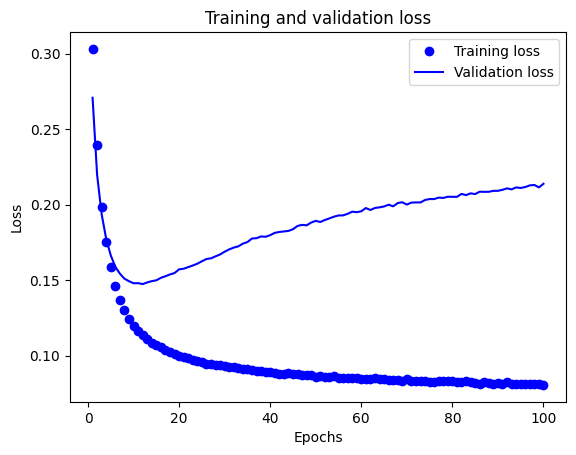

In [13]:
# Cell 11: Plot training and validation loss
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

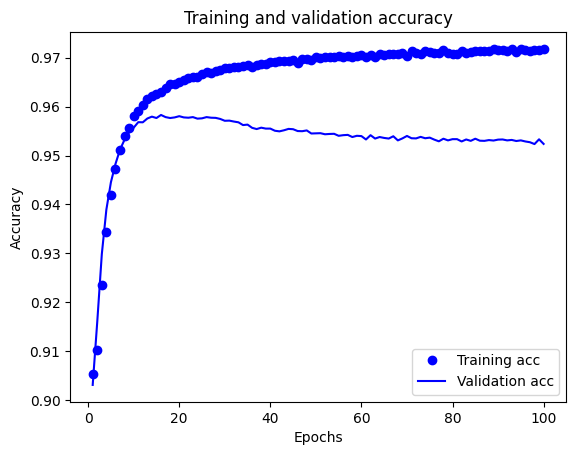

In [14]:
# Cell 12: Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [15]:
# Cell 13: Define export model and compile it
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [16]:
# Cell 14: Evaluate the export model on the test dataset
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

4987/4987 [==============================] - 4s 705us/step - loss: 0.1069 - accuracy: 0.9700
0.9699882864952087


In [17]:
# Cell 15: Define examples for prediction and make predictions
examples = [
    "YOU ARE A TERRIBLE PERSON AND I WANT YOU TO DIE",
    "You are my favrite person in the world, I love you so much",
    "YOU SUCK BECAUSE OF YOUR RELIGION I HATE YOU YOU SUCK"
]

predictions = export_model.predict(examples)

print(predictions)

1/1 [==============================] - 0s 47ms/step
[[0.95243657]
 [0.33075976]
 [0.99998605]]


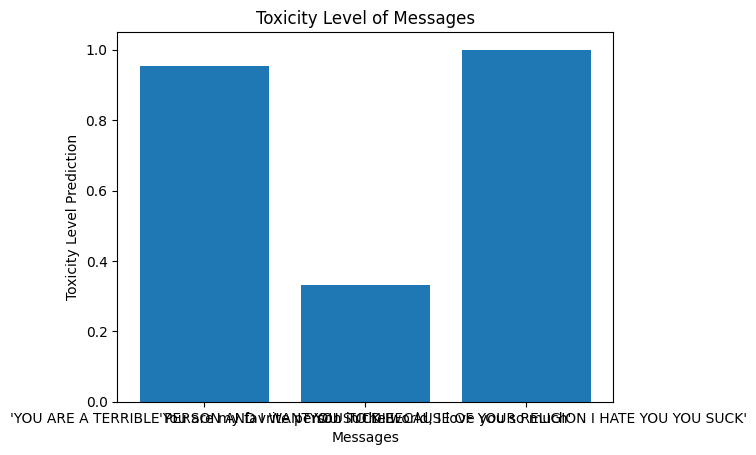

In [18]:
# Cell 16: Plot the predictions
plot_predictions = predictions.flatten()

plot_examples = []

for example in examples:
    plot_examples.append(f"'{example}'")

# Create a bar graph
plt.bar(plot_examples, plot_predictions)

# Add labels and title
plt.xlabel('Messages')
plt.ylabel('Toxicity Level Prediction')
plt.title('Toxicity Level of Messages')

# Display the graph
plt.show()

In [19]:
# Cell 16: Save the export model
will_save = input("Save the model? (y/n) ")
if will_save == "y":
    export_model.save('UMsave.keras')
else:
    print("Model not saved.")